# Future Projection

This notebook contains the projection for the year following the last data collection date.
Task 2 of the instructions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta

## Import data

In [2]:
segm_count_1day = pd.read_csv('Segmented_count_1day.csv',index_col='Timestamp',parse_dates=True)
segm_count_1day.head()

1-2  3-9  10-99  >100
Timestamp                        
2015-05-31   56   45     40   131
2015-06-01   63   60     42   130
2015-06-02   64   61     39   125
2015-06-03   78   46     53   121
2015-06-04   69   46     55   119

### Aggregate total

In [3]:
total = segm_count_1day.copy()
total['devices']=np.sum(total,axis=1)
total.drop(columns=total.columns[0:4],inplace=True)
total.head()

devices
Timestamp          
2015-05-31      272
2015-06-01      295
2015-06-02      289
2015-06-03      298
2015-06-04      289

### Time series analysis

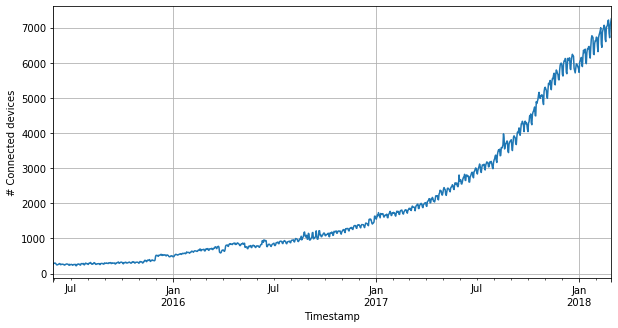

In [4]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot()
total.devices.plot.line(ax = ax1);
plt.grid();
plt.ylabel('# Connected devices');

The general trend is of growth over time.

The series presents a significant weekly seasonality (see next graph).

In particular, the graph shows the last 90 days of data collection. Around the Christmas break 2017 (25Dec-8Jan) there is an evident drop. The growing trend resumes normally after this period.

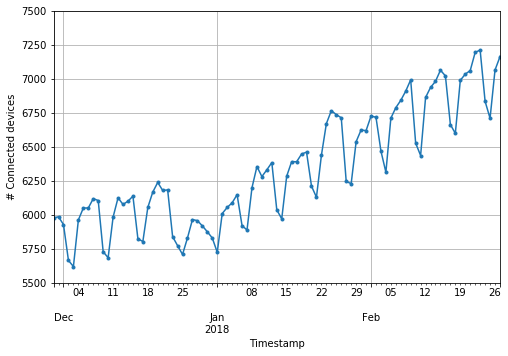

In [5]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot()
total.devices.plot.line(ax = ax1,marker='.');
ax1.set_xlim(17589-90,17589);
ax1.set_ylim(5500,7500)
plt.grid();
plt.ylabel('# Connected devices');

To highlight the general trend a rolling mean function will be used. Due to weekly seasonality, it is recommended to use a window size which is an uneven multiple of 7. In this way, the windowing will always contain all week days, resulting in an even averaging. A 35-day window will be used

In [11]:
# window size
w=35 
# rolling mean
total['rm'] = total.devices.rolling(w,center=True).mean()

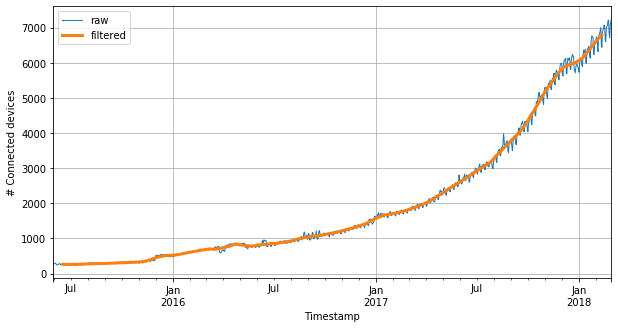

In [10]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot()
total.devices.plot.line(ax=ax1, label = 'raw',linewidth=1);
total.rm.plot.line(ax = ax1, linewidth=3, label = 'filtered');
plt.legend();
ax1.set_ylabel('# Connected devices')
plt.grid();


Excluding the Christmas 2017 drop, the graph curvature changes in the second half of 2017, meaning the growth rate has reached a peak and then falls.

To identify the peak point, we'll proceed with a numerical differentiation

In [ ]:
# rolling mean differential (~growth rate)
total['rmdiff'] = total.rm.diff()

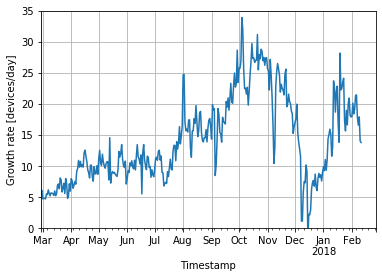

In [13]:
rg = 365 # display range
fig= plt.figure();
ax2 = fig.add_subplot()
total.rmdiff.plot.line(ax = ax2);
plt.grid();
ax2.set_xlim(17589-rg,17589);
ax2.set_ylim(0,35);
ax2.set_ylabel('Growth rate [devices/day]');

The growth rate peak is in mid-October

## Projection

In order to predict the future trend it is necessary to make some assumptions. Since the data available show a growth peak, a sensible model to use is based on [Rogers' curve of adoption](https://en.wikipedia.org/wiki/Diffusion_of_innovations).

According to this model, new users are categorised according to their attitude to new products. The result is a typical trend in product adoption. (Graph taken from Wikipedia)

<img src="files/1200px-Diffusion_of_ideas.svg.png" width=500>

Having identified the point where the growth peak occurs, we'll proceed with extrapolation by making use of the curve symmetry.

Note: A critical moment in the curve is passing from early adopters to early majority, event that is called 'Crossing the chasm'. You guys are past that point, so well done! You've made it!

## Extrapolation function

In [16]:
def series_extrapolation(total, peakdate, lag=0):
    # This series extrapolates a curve using the antisymmetry around the peak date.
    # Consistent with Rogers' curve
    
    # peakdate is datetime where peak growth rate occurs
    # lag - time shift in days [optional]
    #
    forecast_end_date = datetime(2019,2,28) # end of prediction
    delta = forecast_end_date - peakdate # time delta between end_date and peak_date
    # use lag to shift signal if required [optional]
    corrdelta = delta - timedelta(days=lag)
    startdate= peakdate-corrdelta # date where rm data collection starts
    #
    sub = total.copy()
    sub = total[(total.index>= startdate) & (total.index<peakdate)] # extract dates of interest
    subval = sub.rm.values; 
    # extract rm value in correspondence of peak velocity
    peakvalue = total.loc[peakdate]['rm']
    # 
    valdelta = subval-peakvalue
    # predicted values for the extrapolation
    newval = peakvalue-valdelta
    # flip values
    newval = newval[-1::-1]
    # start date for extrapolation dataframe
    startextr = peakdate + timedelta(days=(lag+1)) # 
    extr = pd.DataFrame(newval, index=pd.date_range(startextr,forecast_end_date),\
                        columns=['prediction'])
    return extr

In [17]:
# peak date is assumed to be on 20/10/17
projection =  series_extrapolation(total, peakdate=datetime(2017,10,20), lag=0)

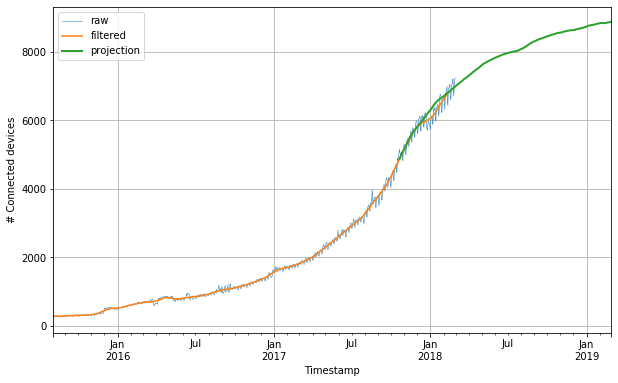

In [24]:
fig = plt.figure(figsize=(10,6));
ax =fig.add_subplot();
total.devices.plot.line(linewidth=.5,label='raw')
total.rm.plot.line(label='filtered');
projection.prediction.plot.line(linewidth=2,label='projection');
rg=1304
ax.set_xlim(17955-rg,17955);
plt.grid();
plt.legend();
plt.ylabel('# Connected devices');

In [22]:
projection.prediction[-1]

8880.285714285714

The model predicts that after a year the number of connected devices will reach more than 8800.

The model is simplified and potentially overly conservative. It will be necessary to monitor the actual evolution vs. prediction.